# Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf

!pip install shap
import shap

#from keras import backend as K
from sklearn.model_selection import StratifiedKFold

2023-08-06 11:13:56.764397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Import Data
train_pitchers = pd.read_csv('Train Test Data/arb_train_pitchers.csv')
test_pitchers = pd.read_csv('Train Test Data/arb_test_pitchers.csv')

for i in [train_pitchers, test_pitchers]:
    i.drop('index', axis = 1, inplace=True)

In [3]:
test_pitchers.head()

,Name,Prev. Season,Position,Service Time,Salary,Age,W,L,G,GS,...,IFH%,BUH%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,Prev. Salary
0,A.J. Minter,2022,RP,4,4287500,28,5,4,75,0,...,3.3,33.3,38.3,69.9,51.4,57.6,78.8,69.5,41.3,2200000.0
1,Aaron Civale,2022,SP,3,2600000,27,5,6,20,20,...,5.2,100.0,33.7,66.6,46.7,64.5,88.0,77.7,39.4,716900.0
2,Adam Cimber,2022,RP,4,3150000,31,10,6,77,0,...,8.0,16.7,32.1,71.1,50.6,73.3,86.6,82.2,47.5,1575000.0
3,Adrian Houser,2022,SP,4,3600000,29,6,10,22,21,...,6.4,100.0,29.6,66.2,43.0,78.1,90.4,85.0,36.5,2425000.0
4,Adrian Morejon,2022,RP,3,800000,23,5,1,26,0,...,27.3,0.0,33.0,76.4,53.7,68.8,82.7,78.3,47.8,704500.0


# EDA

## Descriptive Stats

In [4]:
train_pitchers.columns

Index(['Name', 'Prev. Season', 'Position', 'Service Time', 'Salary', 'Age',
       'W', 'L', 'G', 'GS', 'CG', 'ShO', 'HLD', 'SV', 'BS', 'IP', 'Start-IP',
       'Relief-IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP',
       'BK', 'IFFB', 'SO', 'GB', 'FB', 'LD', 'BABIP', 'AVG', 'WHIP', 'ERA',
       'xERA', 'ERA-', 'FIP', 'xFIP', 'FIP-', 'xFIP-', 'WAR', 'WPA', 'neg_WPA',
       'pos_WPA', 'RS/9', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%',
       'TTO%', 'CStr%', 'SwStr%', 'K-BB%', 'CSW%', 'K/9', 'BB/9', 'H/9',
       'HR/9', 'RE24', 'SIERA', 'HR/FB', 'LOB%', 'GB/FB', 'LD%', 'GB%', 'FB%',
       'IFFB%', 'IFH%', 'BUH%', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%',
       'Z-Contact%', 'Contact%', 'Zone%', 'Prev. Salary'],
      dtype='object')

In [5]:
# Descriptive stats, subset of continuous features
train_pitchers.describe().transpose().head(10)

,count,mean,std,min,25%,50%,75%,max
Prev. Season,1120.0,2.016326e+03,3.093140e+00,2011.0,2014.0,2017.0,2019.00,2021.0
Service Time,1120.0,3.541071e+00,9.038250e-01,2.0,3.0,3.0,4.00,5.0
Salary,1120.0,3.184119e+06,2.614542e+06,550000.0,1300000.0,2300000.0,4200000.00,19750000.0
Age,1120.0,2.772232e+01,2.020591e+00,22.0,26.0,28.0,29.00,36.0
W,1120.0,4.663393e+00,4.060545e+00,0.0,2.0,4.0,7.00,22.0
L,1120.0,4.367857e+00,3.706194e+00,0.0,2.0,3.5,6.00,17.0
G,1120.0,3.921518e+01,2.263877e+01,0.0,23.0,33.0,61.25,82.0
GS,1120.0,8.476786e+00,1.191433e+01,0.0,0.0,0.0,18.00,34.0
CG,1120.0,1.616071e-01,5.311975e-01,0.0,0.0,0.0,0.00,5.0
ShO,1120.0,7.857143e-02,3.370027e-01,0.0,0.0,0.0,0.00,3.0


In [6]:
# Descriptive stats, chase/contact stats
train_pitchers.describe().transpose().tail(8)

,count,mean,std,min,25%,50%,75%,max
O-Swing%,1120.0,3.008277e+01,7.096163e+00,0.0,28.600,31.10,33.500,47.4
Z-Swing%,1120.0,6.429937e+01,1.362630e+01,0.0,63.700,66.80,69.625,84.3
Swing%,1120.0,4.507821e+01,9.574733e+00,0.0,44.600,46.80,48.800,63.9
O-Contact%,1120.0,6.006821e+01,1.492142e+01,0.0,55.875,62.80,68.525,100.0
Z-Contact%,1120.0,8.167830e+01,1.691909e+01,0.0,81.775,85.15,87.900,100.0
Contact%,1120.0,7.343884e+01,1.568308e+01,0.0,72.600,76.55,80.100,100.0
Zone%,1120.0,4.205562e+01,9.146047e+00,0.0,41.100,43.70,46.100,56.7
Prev. Salary,852.0,2.180215e+06,1.962977e+06,450000.0,623750.000,1400000.00,3071875.000,14000000.0


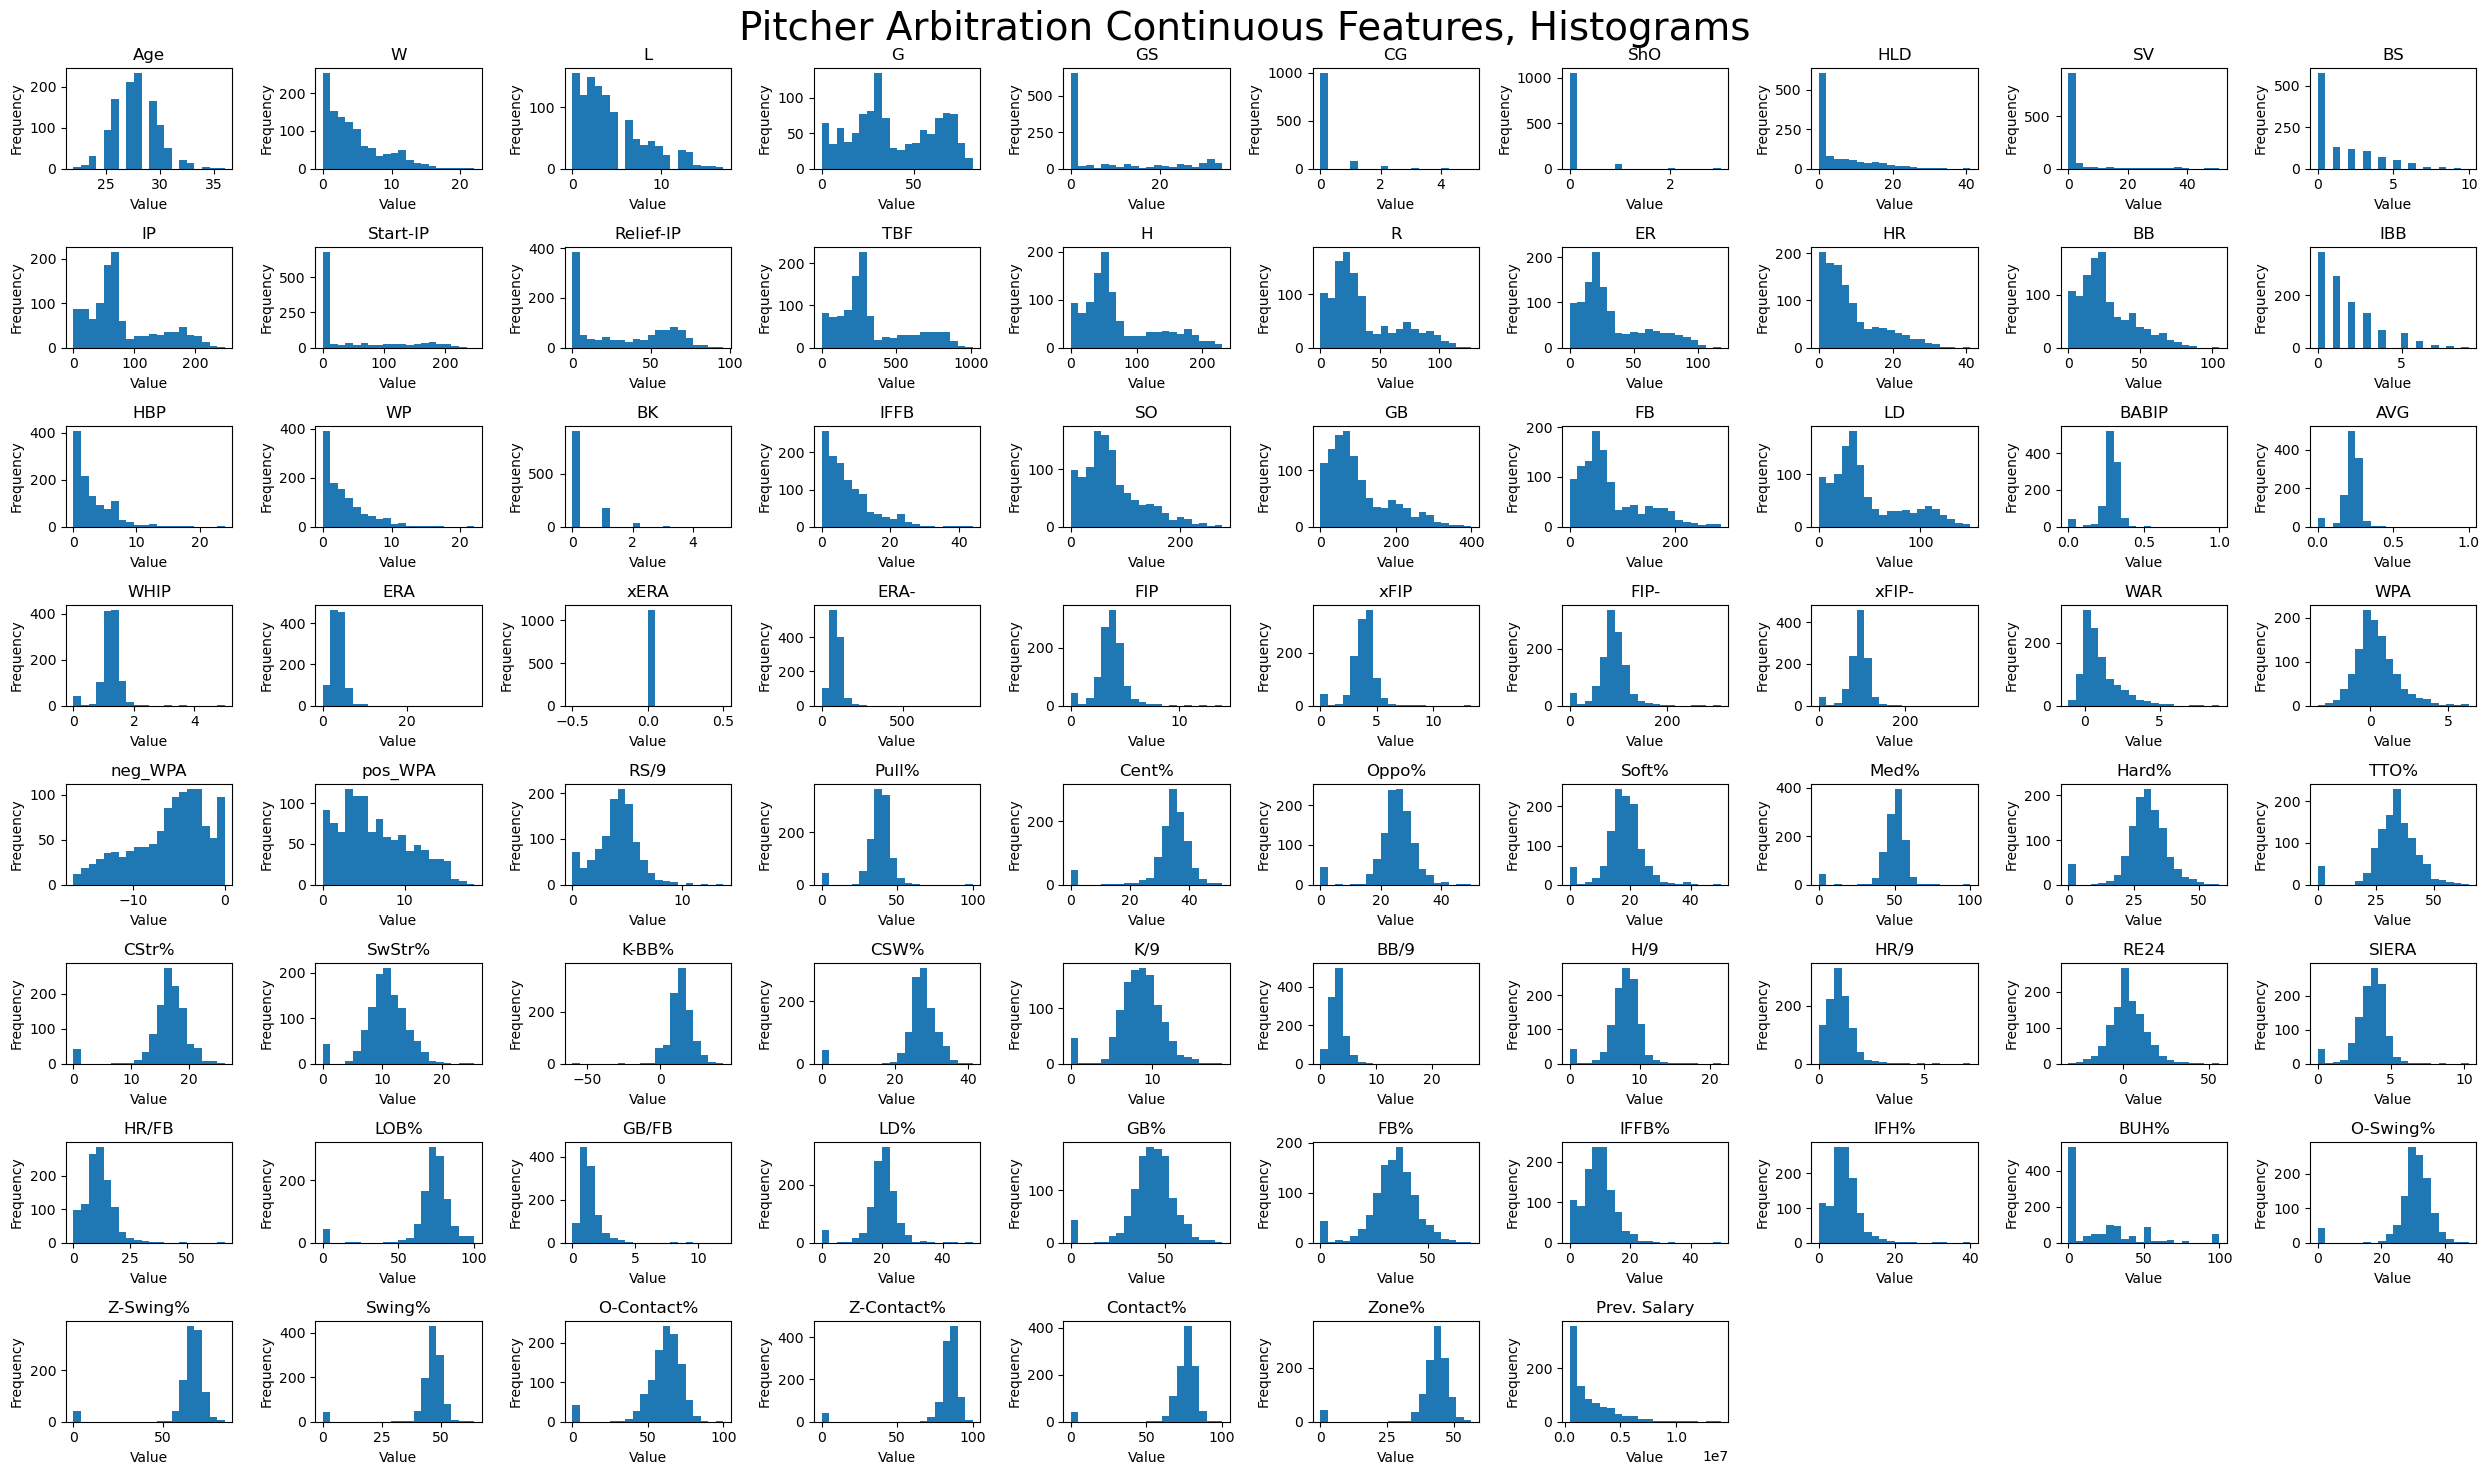

In [7]:
from hists import plot_histograms

# Visualize distributions of all continuous variables
cont_features = train_pitchers.iloc[:,5:]
plot_histograms(cont_features,'Pitcher Arbitration Continuous Features, Histograms')

## Missing Values

In [8]:
# Find all missing values, training set
na_vals_train = train_pitchers.isna().sum()
na_vals_train[na_vals_train > 0]

Prev. Salary    268
dtype: int64

In [9]:
train_pitchers[train_pitchers['Prev. Salary'].isna()]

,Name,Prev. Season,Position,Service Time,Salary,Age,W,L,G,GS,...,IFH%,BUH%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,Prev. Salary
0,A.J. Griffin,2016,SP,4,2000000,28,7,4,23,23,...,4.0,0.0,27.0,65.7,44.1,68.8,84.9,79.4,44.1,NaN
3,AJ Ramos,2015,RP,3,3400000,28,2,4,71,0,...,2.9,0.0,34.0,66.2,46.7,44.6,82.4,65.7,39.5,NaN
6,Aaron Crow,2013,RP,3,1475000,26,7,5,57,0,...,7.4,25.0,28.7,67.9,46.1,52.0,89.5,76.5,44.3,NaN
8,Aaron Loup,2015,RP,3,1050000,27,2,5,60,0,...,13.0,0.0,28.9,62.1,44.7,60.9,86.9,78.0,47.4,NaN
20,Adam Ottavino,2014,RP,3,1300000,28,1,4,75,0,...,7.1,0.0,32.9,60.7,45.9,57.1,86.3,75.2,46.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,Yusmeiro Petit,2013,RP,3,845000,28,4,1,8,7,...,0.0,0.0,39.6,68.1,50.9,64.7,85.2,75.6,39.7,NaN
1108,Zach McAllister,2015,RP,3,1300000,27,4,4,61,1,...,9.9,50.0,25.3,68.9,47.4,66.9,83.4,79.0,50.6,NaN
1111,Zach Putnam,2015,RP,2,975000,27,3,3,49,0,...,12.0,0.0,37.2,67.9,47.9,45.3,83.2,64.1,34.9,NaN
1113,Zack Britton,2014,RP,2,3200000,26,3,2,71,0,...,7.5,20.0,28.9,65.4,46.2,48.8,82.9,71.7,47.5,NaN


In [10]:
# Find all missing values, test set
na_vals_test = test_pitchers.isna().sum()
na_vals_test[na_vals_test > 0]

Prev. Salary    10
dtype: int64

In [11]:
# Find all pitchers with NA salaries in 2022
na_names = test_pitchers[test_pitchers['Prev. Salary'].isna()].Name
test_pitchers[test_pitchers['Prev. Salary'].isna()]

,Name,Prev. Season,Position,Service Time,Salary,Age,W,L,G,GS,...,IFH%,BUH%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,Prev. Salary
5,Adrian Sampson,2022,SP,2,1900000,30,4,5,21,19,...,6.2,0.0,33.8,71.5,47.9,70.1,89.0,80.7,37.5,NaN
21,Carl Edwards Jr.,2022,RP,5,2250000,30,6,3,57,0,...,6.0,0.0,34.0,68.8,47.9,64.3,87.4,77.5,39.9,NaN
27,Colin Poche,2022,RP,3,1175000,28,4,2,65,0,...,10.0,0.0,35.9,73.0,51.2,68.3,79.9,75.2,41.4,NaN
53,Hunter Harvey,2022,RP,3,870000,27,2,1,38,0,...,12.8,0.0,32.2,71.1,49.5,62.7,83.3,75.8,44.5,NaN
58,Jakob Junis,2022,SP,5,2800000,29,5,7,23,17,...,5.3,33.3,32.1,61.1,45.4,64.9,88.1,79.2,45.8,NaN
62,Jeff Brigham,2022,RP,3,760000,30,0,1,16,0,...,8.3,0.0,33.7,65.3,46.5,63.1,82.9,74.4,40.6,NaN
75,Jose Castillo,2022,RP,3,730000,26,0,0,1,0,...,0.0,0.0,37.5,87.5,62.5,33.3,85.7,70.0,50.0,NaN
112,Ryan Thompson,2022,RP,3,1000000,30,3,3,47,0,...,10.8,50.0,35.3,62.8,46.5,69.0,85.6,78.2,40.8,NaN
115,Scott Alexander,2022,RP,5,1200000,32,0,0,17,4,...,8.1,50.0,39.5,64.7,49.5,68.6,85.5,77.4,39.7,NaN
135,Yency Almonte,2022,RP,3,1500000,28,0,0,33,0,...,4.7,0.0,33.8,64.2,45.5,48.5,86.1,68.9,38.4,NaN


# Preprocessing

## Handling Missing Values

After handling missing values for some pitcher (extensions), the rest are assumed to be pitchers who were non-tendered in the past before reaching arbitration for the first time, or were signed to minor-league deals, thus making the league minimum if they played in the major leagues.

Any missing values will be imputed with the league minimum salary, which differs from year-to-year. The link to find minimum salary figures is here: https://www.baseball-reference.com/bullpen/Minimum_salary

In [12]:
# View missing values for each preceeding season
train_pitchers[train_pitchers['Prev. Salary'].isna()]['Prev. Season'].value_counts().sort_index()

2011    34
2012    37
2013    42
2014    40
2015    48
2016    48
2018     2
2019     7
2020     3
2021     7
Name: Prev. Season, dtype: int64

In [13]:
# Define league minimums for each preceeding season, fill in na previous salaires
minimums = {2011 : 414000, 
            2012: 480000, 
            2013: 480000, 
            2014: 480000, 
            2015: 507500,
            2016: 507500,
            2017: 535000,
            2018: 545000,
            2019: 545000,
            2020: 563500,
            2021: 563500}

train_pitchers['Prev. Salary'] = train_pitchers['Prev. Salary'].fillna(train_pitchers['Prev. Season'].map(minimums))

In [14]:
# Check: NA values in training set filled in with league minimums
print((train_pitchers.isna().sum() == 0).value_counts(),'\n')
train_pitchers[train_pitchers['Prev. Salary'] == 414000].head()

True    82
dtype: int64 



,Name,Prev. Season,Position,Service Time,Salary,Age,W,L,G,GS,...,IFH%,BUH%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,Prev. Salary
45,Alfredo Aceves,2011,RP,3,1200000,28,10,2,55,4,...,4.5,0.0,30.0,67.8,46.6,73.8,89.1,83.6,44.0,414000.0
52,Andrew Bailey,2011,RP,3,3900000,27,0,4,42,0,...,16.3,0.0,32.8,67.2,48.7,64.8,86.5,78.6,46.2,414000.0
65,Andrew Miller,2011,RP,3,1040000,26,6,3,17,12,...,7.4,44.4,26.7,63.9,43.3,71.4,88.6,82.7,44.6,414000.0
105,Brad Bergesen,2011,RP,2,800000,25,2,7,34,12,...,9.5,0.0,27.6,67.1,46.8,78.6,90.9,87.2,48.5,414000.0
199,Charlie Morton,2011,SP,3,2445000,27,10,10,29,29,...,5.6,5.3,31.2,65.4,45.7,72.3,90.7,83.5,42.5,414000.0


In [15]:
# Fill in test set with league minimum for 2022
test_pitchers = test_pitchers.fillna(700000)

In [16]:
# Check: NA values in test set filled in with league minimum
print((test_pitchers.isna().sum() == 0).value_counts(),'\n')
test_pitchers[test_pitchers.Name.isin(na_names)]

True    82
dtype: int64 



,Name,Prev. Season,Position,Service Time,Salary,Age,W,L,G,GS,...,IFH%,BUH%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,Prev. Salary
5,Adrian Sampson,2022,SP,2,1900000,30,4,5,21,19,...,6.2,0.0,33.8,71.5,47.9,70.1,89.0,80.7,37.5,700000.0
21,Carl Edwards Jr.,2022,RP,5,2250000,30,6,3,57,0,...,6.0,0.0,34.0,68.8,47.9,64.3,87.4,77.5,39.9,700000.0
27,Colin Poche,2022,RP,3,1175000,28,4,2,65,0,...,10.0,0.0,35.9,73.0,51.2,68.3,79.9,75.2,41.4,700000.0
53,Hunter Harvey,2022,RP,3,870000,27,2,1,38,0,...,12.8,0.0,32.2,71.1,49.5,62.7,83.3,75.8,44.5,700000.0
58,Jakob Junis,2022,SP,5,2800000,29,5,7,23,17,...,5.3,33.3,32.1,61.1,45.4,64.9,88.1,79.2,45.8,700000.0
62,Jeff Brigham,2022,RP,3,760000,30,0,1,16,0,...,8.3,0.0,33.7,65.3,46.5,63.1,82.9,74.4,40.6,700000.0
75,Jose Castillo,2022,RP,3,730000,26,0,0,1,0,...,0.0,0.0,37.5,87.5,62.5,33.3,85.7,70.0,50.0,700000.0
112,Ryan Thompson,2022,RP,3,1000000,30,3,3,47,0,...,10.8,50.0,35.3,62.8,46.5,69.0,85.6,78.2,40.8,700000.0
115,Scott Alexander,2022,RP,5,1200000,32,0,0,17,4,...,8.1,50.0,39.5,64.7,49.5,68.6,85.5,77.4,39.7,700000.0
135,Yency Almonte,2022,RP,3,1500000,28,0,0,33,0,...,4.7,0.0,33.8,64.2,45.5,48.5,86.1,68.9,38.4,700000.0


## (More) Feature Engineering

In [17]:
# Drop Name, Prev. Season, Statcast features
train_pitchers = train_pitchers.drop(['Name','Prev. Season','xERA'],axis=1)

test_pitcher_names = test_pitchers.Name
test_pitchers = test_pitchers.drop(['Name','Prev. Season','xERA'],axis=1)

### Scaling, Normalization, OHC

From histograms generated to visualize how each of our continuous features are distributed, we define a ColumnTransformer object in SciKit Learn with StandardScaler, MinMaxScaler, and OneHotEncoder objects.

In [18]:
# Define all columns to appropriately scale, normalize, or OHC
ohc_cols = ['Position', 'Service Time']
minmax_cols = ['W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'IP', 'Start-IP', 'Relief-IP', 
               'TBF', 'H', 'ER', 'HR', 'BB', 'IBB', 'HBP','WP', 'BK', 'IFFB',
               'SO', 'GB', 'FB', 'LD', 'neg_WPA', 'pos_WPA', 'BUH%', 'Prev. Salary']



norm_cols = [i for i in train_pitchers.columns if i not in ohc_cols and i not in minmax_cols and i != 'Salary']

In [19]:
# Filter to X and y values, changing order to align with preprocessing steps
train_pitchers_y = np.array(train_pitchers.Salary)
train_pitchers_X = train_pitchers[minmax_cols + norm_cols + ohc_cols]

train_pitchers_X.head()

,W,L,G,GS,CG,ShO,SV,BS,IP,Start-IP,...,IFH%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,Position,Service Time
0,7,4,23,23,0,0,0,0,119.00,119.0,...,4.0,27.0,65.7,44.1,68.8,84.9,79.4,44.1,SP,4
1,1,1,22,0,0,0,0,0,21.67,0.0,...,4.0,31.0,74.4,49.4,64.8,76.0,71.9,42.3,RP,2
2,3,6,61,0,0,0,0,6,52.33,0.0,...,9.5,34.2,67.2,49.0,53.9,81.4,70.9,44.9,RP,3
3,2,4,71,0,0,0,32,6,70.33,0.0,...,2.9,34.0,66.2,46.7,44.6,82.4,65.7,39.5,RP,3
4,1,4,67,0,0,0,40,3,64.00,0.0,...,5.1,27.3,61.0,41.9,49.7,83.8,71.2,43.2,RP,4


In [20]:
# Create the ColumnTransformer with all transformations in one step
# Apply Normalization to normally distributed continuous features
# Apply MinMax Scaling to non-normally distributed continuous features

preprocessor = ColumnTransformer(transformers=[
    ('numeric_minmax', MinMaxScaler(), minmax_cols),
    ('numeric_standard', StandardScaler(), norm_cols),
    ('categorical_onehot', OneHotEncoder(handle_unknown = 'ignore'), ohc_cols)
])
preprocessor.fit(train_pitchers_X)

# Get column names from preprocessor (for feature importance)
column_names = preprocessor.get_feature_names_out(input_features=train_pitchers_X.columns)

# Fit and transform the data
train_pitchers_X = preprocessor.transform(train_pitchers_X)
train_pitchers_X

array([[0.31818182, 0.23529412, 0.2804878 , ..., 0.        , 1.        ,
        0.        ],
       [0.04545455, 0.05882353, 0.26829268, ..., 0.        , 0.        ,
        0.        ],
       [0.13636364, 0.35294118, 0.74390244, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.13636364, 0.41176471, 0.20731707, ..., 0.        , 1.        ,
        0.        ],
       [0.54545455, 0.41176471, 0.35365854, ..., 0.        , 0.        ,
        1.        ]])

## Dataset Splitting

In [21]:
# Split training set into training-validation sets
X_train, X_valid, y_train, y_valid = train_test_split(train_pitchers_X, train_pitchers_y, 
                                                      test_size=0.25, random_state=64)

# Neural Net Building, Compiling

## Define Keras Neural Net, Train

### Define Parameters

In [22]:
# Params
n_epochs = 300
l_rate = 0.0005
num_cols = X_train.shape[1]

# Defines Keras Sequentual Mode
arb_nnet = tf.keras.Sequential([
    tf.keras.layers.Dense(num_cols, activation='relu', input_shape=(num_cols,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

## Train

In [23]:
# Define optimizer and return metrics for neural net, compile
nn_optimizer = tf.keras.optimizers.Adam(learning_rate=l_rate)
nn_metrics = [tf.keras.metrics.MeanAbsoluteError(),
              tf.keras.metrics.MeanAbsolutePercentageError()]

arb_nnet.compile(optimizer= nn_optimizer,
          loss='mean_absolute_error',
          metrics=nn_metrics)

# Fit the neural net
history = arb_nnet.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=n_epochs, batch_size=24)

# Evaluate model on validation set, return metrics
loss_nn, mae_nn, mape_nn = arb_nnet.evaluate(X_valid, y_valid)


# Define DataFrame for loss and metrics over each epoch of training 
loss_df = pd.DataFrame(columns=['Epochs','train_MAE', 'val_MAE','train_MAPE','val_MAPE'])

# Return loss and mae values over time from training epochs
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

mae = history_dict['mean_absolute_error']
val_mae = history_dict['val_mean_absolute_error']

mape = history_dict['mean_absolute_percentage_error']
val_mape = history_dict['val_mean_absolute_percentage_error']

# Add all metrics to dictionary, convert to Dataframe & return
epochs = [i for i in range(1, n_epochs + 1)]

loss_dict = {'train_MAE':mae, 'val_MAE': val_mae, 'train_MAPE': mape, 'val_MAPE': val_mape}

nnet_loss = pd.DataFrame.from_dict(loss_dict).reset_index().melt(id_vars=['index'])
nnet_loss['index'] = nnet_loss['index'] + 1

Epoch 1/300
35/35 [==============================] - 4s 25ms/step - loss: 3209748.7500 - mean_absolute_error: 3209748.7500 - mean_absolute_percentage_error: 99.9997 - val_loss: 3107191.2500 - val_mean_absolute_error: 3107191.2500 - val_mean_absolute_percentage_error: 99.9989
Epoch 2/300
35/35 [==============================] - 0s 7ms/step - loss: 3209608.0000 - mean_absolute_error: 3209608.0000 - mean_absolute_percentage_error: 99.9919 - val_loss: 3106761.2500 - val_mean_absolute_error: 3106761.2500 - val_mean_absolute_percentage_error: 99.9757
Epoch 3/300
35/35 [==============================] - 0s 7ms/step - loss: 3207766.0000 - mean_absolute_error: 3207766.5000 - mean_absolute_percentage_error: 99.8951 - val_loss: 3102248.0000 - val_mean_absolute_error: 3102248.0000 - val_mean_absolute_percentage_error: 99.7376
Epoch 4/300
35/35 [==============================] - 0s 9ms/step - loss: 3195085.7500 - mean_absolute_error: 3195086.0000 - mean_absolute_percentage_error: 99.2315 - val_loss

Epoch 31/300
35/35 [==============================] - 0s 4ms/step - loss: 1144357.8750 - mean_absolute_error: 1144357.8750 - mean_absolute_percentage_error: 37.4233 - val_loss: 1039668.9375 - val_mean_absolute_error: 1039668.9375 - val_mean_absolute_percentage_error: 35.3166
Epoch 32/300
35/35 [==============================] - 0s 5ms/step - loss: 1145181.3750 - mean_absolute_error: 1145181.3750 - mean_absolute_percentage_error: 37.7680 - val_loss: 1033645.5000 - val_mean_absolute_error: 1033645.5000 - val_mean_absolute_percentage_error: 34.6428
Epoch 33/300
35/35 [==============================] - 0s 6ms/step - loss: 1133181.2500 - mean_absolute_error: 1133181.2500 - mean_absolute_percentage_error: 36.6307 - val_loss: 1025834.5000 - val_mean_absolute_error: 1025834.5000 - val_mean_absolute_percentage_error: 34.4906
Epoch 34/300
35/35 [==============================] - 0s 4ms/step - loss: 1097771.7500 - mean_absolute_error: 1097771.7500 - mean_absolute_percentage_error: 36.0777 - val_l

Epoch 61/300
35/35 [==============================] - 0s 5ms/step - loss: 886861.8750 - mean_absolute_error: 886861.8750 - mean_absolute_percentage_error: 30.0164 - val_loss: 807279.6250 - val_mean_absolute_error: 807279.6250 - val_mean_absolute_percentage_error: 29.7215
Epoch 62/300
35/35 [==============================] - 0s 6ms/step - loss: 896077.2500 - mean_absolute_error: 896077.2500 - mean_absolute_percentage_error: 30.2735 - val_loss: 804262.5000 - val_mean_absolute_error: 804262.5625 - val_mean_absolute_percentage_error: 29.7894
Epoch 63/300
35/35 [==============================] - 0s 6ms/step - loss: 882173.4375 - mean_absolute_error: 882173.2500 - mean_absolute_percentage_error: 29.8896 - val_loss: 792493.4375 - val_mean_absolute_error: 792493.4375 - val_mean_absolute_percentage_error: 29.4962
Epoch 64/300
35/35 [==============================] - 0s 5ms/step - loss: 876834.4375 - mean_absolute_error: 876834.4375 - mean_absolute_percentage_error: 29.0819 - val_loss: 792604.75

35/35 [==============================] - 0s 5ms/step - loss: 716506.1875 - mean_absolute_error: 716506.1875 - mean_absolute_percentage_error: 25.0886 - val_loss: 678580.8125 - val_mean_absolute_error: 678580.8125 - val_mean_absolute_percentage_error: 25.7106
Epoch 92/300
35/35 [==============================] - 0s 4ms/step - loss: 727159.6875 - mean_absolute_error: 727159.6875 - mean_absolute_percentage_error: 25.2767 - val_loss: 668751.5000 - val_mean_absolute_error: 668751.5000 - val_mean_absolute_percentage_error: 25.7167
Epoch 93/300
35/35 [==============================] - 0s 5ms/step - loss: 713073.8125 - mean_absolute_error: 713073.7500 - mean_absolute_percentage_error: 24.7155 - val_loss: 671079.5625 - val_mean_absolute_error: 671079.5625 - val_mean_absolute_percentage_error: 26.5565
Epoch 94/300
35/35 [==============================] - 0s 5ms/step - loss: 711053.0000 - mean_absolute_error: 711053.0000 - mean_absolute_percentage_error: 24.9630 - val_loss: 667461.5000 - val_mean

35/35 [==============================] - 0s 6ms/step - loss: 637324.2500 - mean_absolute_error: 637324.2500 - mean_absolute_percentage_error: 22.3675 - val_loss: 608506.5625 - val_mean_absolute_error: 608506.5625 - val_mean_absolute_percentage_error: 23.5410
Epoch 122/300
35/35 [==============================] - 0s 5ms/step - loss: 618492.4375 - mean_absolute_error: 618492.4375 - mean_absolute_percentage_error: 20.8832 - val_loss: 611929.1875 - val_mean_absolute_error: 611929.1875 - val_mean_absolute_percentage_error: 24.4777
Epoch 123/300
35/35 [==============================] - 0s 5ms/step - loss: 627463.7500 - mean_absolute_error: 627463.7500 - mean_absolute_percentage_error: 21.3605 - val_loss: 609689.6250 - val_mean_absolute_error: 609689.6250 - val_mean_absolute_percentage_error: 24.0438
Epoch 124/300
35/35 [==============================] - 0s 5ms/step - loss: 631425.8125 - mean_absolute_error: 631425.8125 - mean_absolute_percentage_error: 21.9358 - val_loss: 609885.4375 - val_m

35/35 [==============================] - 0s 5ms/step - loss: 579995.1875 - mean_absolute_error: 579995.1875 - mean_absolute_percentage_error: 20.0615 - val_loss: 565168.1875 - val_mean_absolute_error: 565168.1875 - val_mean_absolute_percentage_error: 22.4429
Epoch 152/300
35/35 [==============================] - 0s 6ms/step - loss: 545200.7500 - mean_absolute_error: 545200.7500 - mean_absolute_percentage_error: 19.0119 - val_loss: 559875.1875 - val_mean_absolute_error: 559875.1875 - val_mean_absolute_percentage_error: 22.4307
Epoch 153/300
35/35 [==============================] - 0s 5ms/step - loss: 542247.8125 - mean_absolute_error: 542247.8125 - mean_absolute_percentage_error: 19.0670 - val_loss: 560882.5625 - val_mean_absolute_error: 560882.5625 - val_mean_absolute_percentage_error: 22.7927
Epoch 154/300
35/35 [==============================] - 0s 5ms/step - loss: 531457.8125 - mean_absolute_error: 531457.8125 - mean_absolute_percentage_error: 18.5651 - val_loss: 558855.1875 - val_m

35/35 [==============================] - 0s 7ms/step - loss: 506765.4375 - mean_absolute_error: 506765.4375 - mean_absolute_percentage_error: 17.4227 - val_loss: 518987.1875 - val_mean_absolute_error: 518987.1562 - val_mean_absolute_percentage_error: 21.1790
Epoch 182/300
35/35 [==============================] - 0s 11ms/step - loss: 481143.5312 - mean_absolute_error: 481143.5312 - mean_absolute_percentage_error: 16.6993 - val_loss: 518390.1562 - val_mean_absolute_error: 518390.1250 - val_mean_absolute_percentage_error: 21.5381
Epoch 183/300
35/35 [==============================] - 0s 9ms/step - loss: 513596.6875 - mean_absolute_error: 513596.6875 - mean_absolute_percentage_error: 17.4288 - val_loss: 519005.7188 - val_mean_absolute_error: 519005.7812 - val_mean_absolute_percentage_error: 20.7703
Epoch 184/300
35/35 [==============================] - 0s 7ms/step - loss: 499836.2188 - mean_absolute_error: 499836.2188 - mean_absolute_percentage_error: 16.8241 - val_loss: 513531.9375 - val_

35/35 [==============================] - 0s 7ms/step - loss: 457683.3125 - mean_absolute_error: 457683.3125 - mean_absolute_percentage_error: 15.9121 - val_loss: 481481.7188 - val_mean_absolute_error: 481481.7188 - val_mean_absolute_percentage_error: 20.7012
Epoch 212/300
35/35 [==============================] - 0s 7ms/step - loss: 466363.1562 - mean_absolute_error: 466363.1562 - mean_absolute_percentage_error: 16.4303 - val_loss: 478905.6250 - val_mean_absolute_error: 478905.6250 - val_mean_absolute_percentage_error: 20.4816
Epoch 213/300
35/35 [==============================] - 0s 7ms/step - loss: 480424.3438 - mean_absolute_error: 480424.3438 - mean_absolute_percentage_error: 16.1314 - val_loss: 477991.3438 - val_mean_absolute_error: 477991.3438 - val_mean_absolute_percentage_error: 19.8954
Epoch 214/300
35/35 [==============================] - 0s 6ms/step - loss: 452700.1875 - mean_absolute_error: 452700.1875 - mean_absolute_percentage_error: 15.9977 - val_loss: 476335.5312 - val_m

35/35 [==============================] - 0s 14ms/step - loss: 447174.6562 - mean_absolute_error: 447174.6562 - mean_absolute_percentage_error: 15.2331 - val_loss: 460611.3125 - val_mean_absolute_error: 460611.3125 - val_mean_absolute_percentage_error: 20.6980
Epoch 242/300
35/35 [==============================] - 0s 8ms/step - loss: 428641.6875 - mean_absolute_error: 428641.6875 - mean_absolute_percentage_error: 14.9742 - val_loss: 462523.3125 - val_mean_absolute_error: 462523.2500 - val_mean_absolute_percentage_error: 20.3370
Epoch 243/300
35/35 [==============================] - 0s 12ms/step - loss: 438098.0938 - mean_absolute_error: 438098.0938 - mean_absolute_percentage_error: 15.3410 - val_loss: 461707.3125 - val_mean_absolute_error: 461707.3125 - val_mean_absolute_percentage_error: 20.2768
Epoch 244/300
35/35 [==============================] - 0s 10ms/step - loss: 445387.9688 - mean_absolute_error: 445387.9688 - mean_absolute_percentage_error: 15.2469 - val_loss: 462207.6562 - va

35/35 [==============================] - 0s 5ms/step - loss: 431522.9062 - mean_absolute_error: 431522.9062 - mean_absolute_percentage_error: 15.5172 - val_loss: 446871.4688 - val_mean_absolute_error: 446871.4688 - val_mean_absolute_percentage_error: 19.7457
Epoch 272/300
35/35 [==============================] - 0s 6ms/step - loss: 426458.1562 - mean_absolute_error: 426458.1562 - mean_absolute_percentage_error: 15.0395 - val_loss: 449240.8125 - val_mean_absolute_error: 449240.8125 - val_mean_absolute_percentage_error: 20.2587
Epoch 273/300
35/35 [==============================] - 0s 5ms/step - loss: 408445.4375 - mean_absolute_error: 408445.4375 - mean_absolute_percentage_error: 14.1219 - val_loss: 450139.5625 - val_mean_absolute_error: 450139.5625 - val_mean_absolute_percentage_error: 20.1102
Epoch 274/300
35/35 [==============================] - 0s 4ms/step - loss: 420737.0625 - mean_absolute_error: 420737.0625 - mean_absolute_percentage_error: 14.8481 - val_loss: 448595.8438 - val_m

9/9 [==============================] - 0s 8ms/step - loss: 437472.2812 - mean_absolute_error: 437472.2812 - mean_absolute_percentage_error: 19.7086


# Performance, Training Data

In [24]:
# Isolate MAE and MAPE from dataframe w/ loss values
nnet_mae = nnet_loss[(nnet_loss.variable == 'train_MAE')| (nnet_loss.variable == 'val_MAE')]
nnet_mape = nnet_loss[(nnet_loss.variable == 'train_MAPE')| (nnet_loss.variable == 'val_MAPE')]

## Learning Curves

In [25]:
sns.set(rc={"figure.figsize":(12, 6)})

Text(0.5, 1.0, 'Train-Val MAE Loss/Epoch, Pitchers')

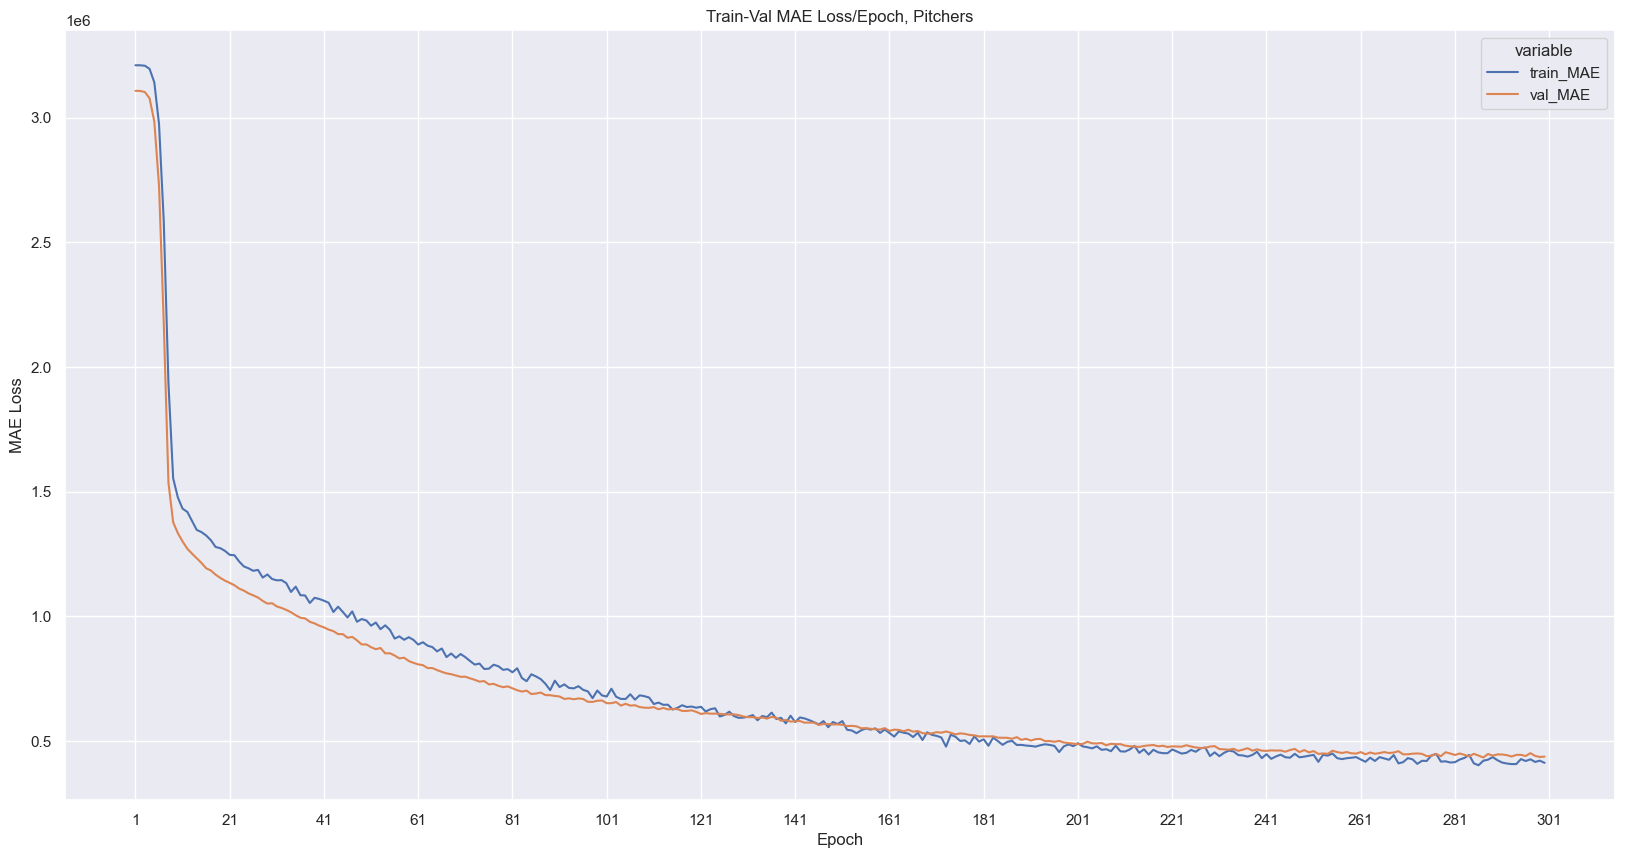

In [26]:
# Create learning curve: MAE per epoch
plt.figure(figsize=(20,10))
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.xticks((np.arange(1,502,20)))
sns.lineplot(data=nnet_mae, x = "index", y="value", hue="variable").set_title('Train-Val MAE Loss/Epoch, Pitchers')

Text(0.5, 1.0, 'Train-Val MAPE Loss/Epoch, Pitchers')

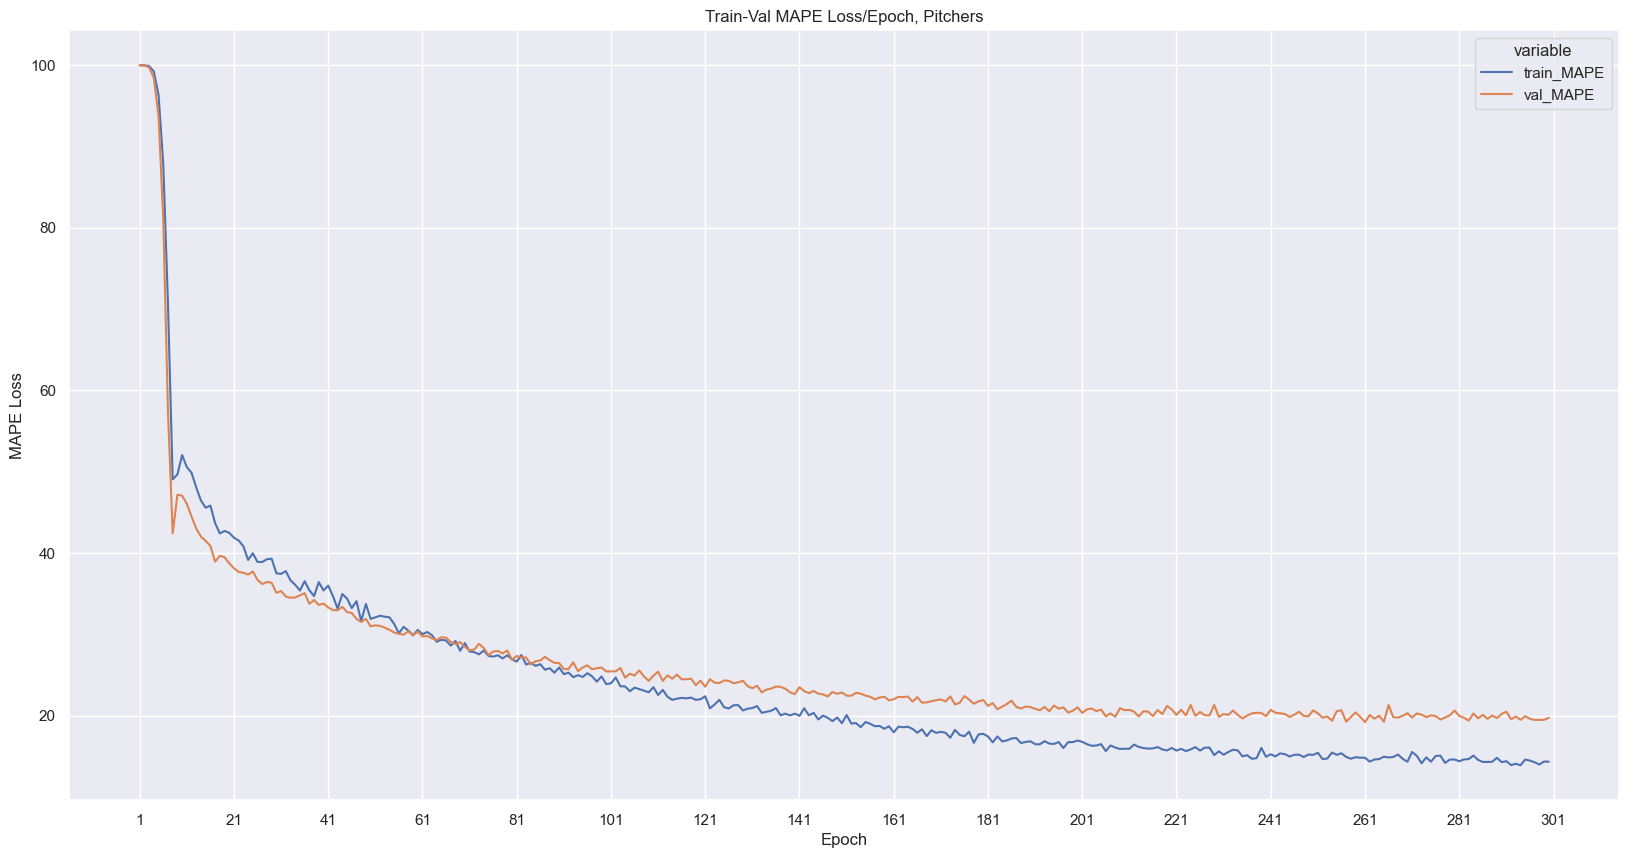

In [27]:
# Create learning curve: MAPE per epoch
plt.figure(figsize=(20,10))
plt.xlabel('Epoch')
plt.ylabel('MAPE Loss')
plt.xticks((np.arange(1,502,20)))
sns.lineplot(data=nnet_mape, x = "index", y="value", hue="variable").set_title('Train-Val MAPE Loss/Epoch, Pitchers')

## Feature Importance

In [28]:
feature_names = [i.replace('numeric_minmax__', '').replace('numeric_standard__','').replace('categorical_onehot__','') for i in column_names]

Permutation explainer: 841it [04:23,  3.16it/s]                                 


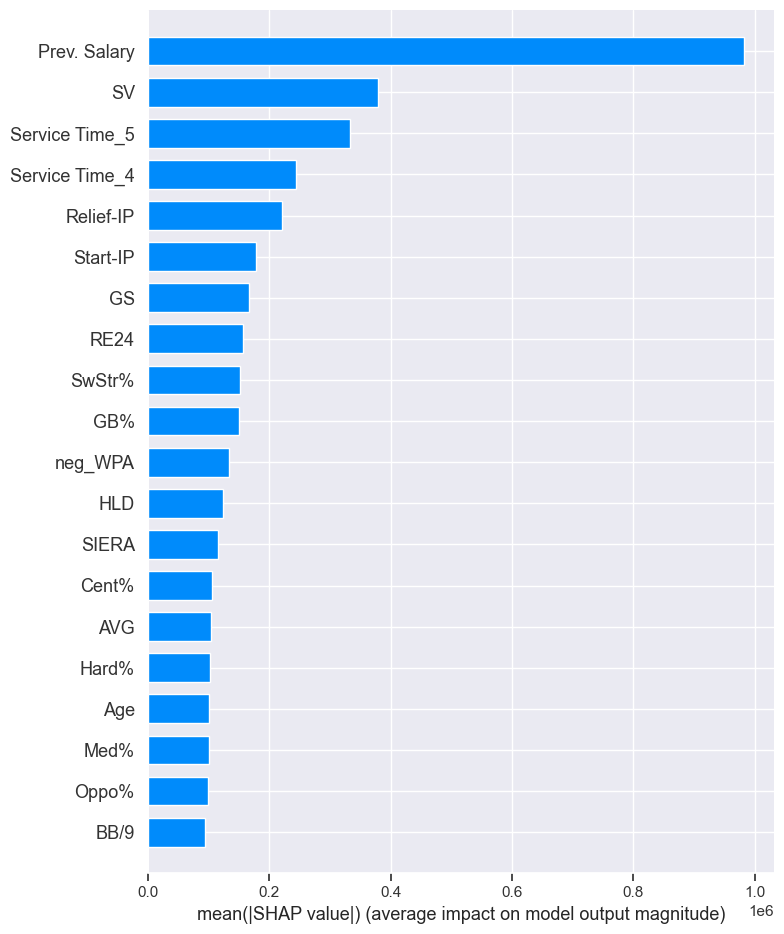

In [29]:
# SHAP feature importance
explainer = shap.Explainer(arb_nnet, X_train)
shap_values = explainer(X_train)

# Summary plot (bar plot of feature importance)
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names = feature_names)

# Performance, Test Data (Predicting 2023 Salaries)

In [30]:
test_pitcher_names = test_pitcher_names

In [31]:
# Split into x and y
test_pitchers_y = np.array(test_pitchers.Salary)
test_pitchers_X = test_pitchers.drop('Salary',axis=1)[minmax_cols + norm_cols + ohc_cols]


# Fit and transform the data
test_pitchers_X = preprocessor.transform(test_pitchers_X)

In [32]:
# Helper function: Rounds all predicted figures to nearest multiple of 10,000
# Done to "clean" predictions
def round_nearest_multiple(number, multiple = 10000):
    return multiple * round(number / multiple)

In [33]:
# Define DataFrame to compare 2023 salary and NNet predicted 2023 Salary
arb23_preds = pd.DataFrame(columns = ["Name", 'Position','Service Time','2023 Salary', 'Predicted 2023 Salary'])
arb23_preds.Name = test_pitcher_names
arb23_preds.Position = test_pitchers.Position
arb23_preds['Service Time'] = test_pitchers['Service Time']
arb23_preds['2023 Salary'] = test_pitchers_y

# Predict Salaries, add to Dataframe
y_test_pred = arb_nnet.predict(test_pitchers_X)
arb23_preds['Predicted 2023 Salary'] = [round_nearest_multiple(float(i)) for i in y_test_pred]

arb23_preds

5/5 [==============================] - 0s 2ms/step


,Name,Position,Service Time,2023 Salary,Predicted 2023 Salary
0,A.J. Minter,RP,4,4287500,4700000
1,Aaron Civale,SP,3,2600000,2040000
2,Adam Cimber,RP,4,3150000,2760000
3,Adrian Houser,SP,4,3600000,3400000
4,Adrian Morejon,RP,3,800000,1400000
...,...,...,...,...,...
134,Wandy Peralta,RP,5,3350000,3490000
135,Yency Almonte,RP,3,1500000,1100000
136,Yonny Chirinos,SP,4,1275000,2260000
137,Zac Gallen,SP,3,5600000,5180000


## Metrics

In [34]:
# Calculate "error" of test set
error_test = sum(np.abs(arb23_preds['2023 Salary'] - arb23_preds['Predicted 2023 Salary']))
med_ae = int(np.median(np.abs(arb23_preds['Predicted 2023 Salary'] - np.median(arb23_preds['Predicted 2023 Salary']))))
print('Total Absolute Error Test Set:', error_test)
print('MAE Test Set:', error_test // arb23_preds.shape[0])
print('Median Absolute Deviation, Test Set:', med_ae)

Total Absolute Error Test Set: 71025000
MAE Test Set: 510971
Median Absolute Deviation, Test Set: 910000


In [35]:
# Lowest predicted salary
arb23_preds[arb23_preds['Predicted 2023 Salary'] == min(arb23_preds['Predicted 2023 Salary'])]

,Name,Position,Service Time,2023 Salary,Predicted 2023 Salary
38,Duane Underwood,RP,3,1025000,560000


In [36]:
# Highest predicted salary
arb23_preds[arb23_preds['Predicted 2023 Salary'] == max(arb23_preds['Predicted 2023 Salary'])]

,Name,Position,Service Time,2023 Salary,Predicted 2023 Salary
79,Josh Hader,RP,5,14100000,14800000


## Visualizations

Text(0.5, 1.0, '2023 Salary vs. Predicted 2023 Salary: Pitchers')

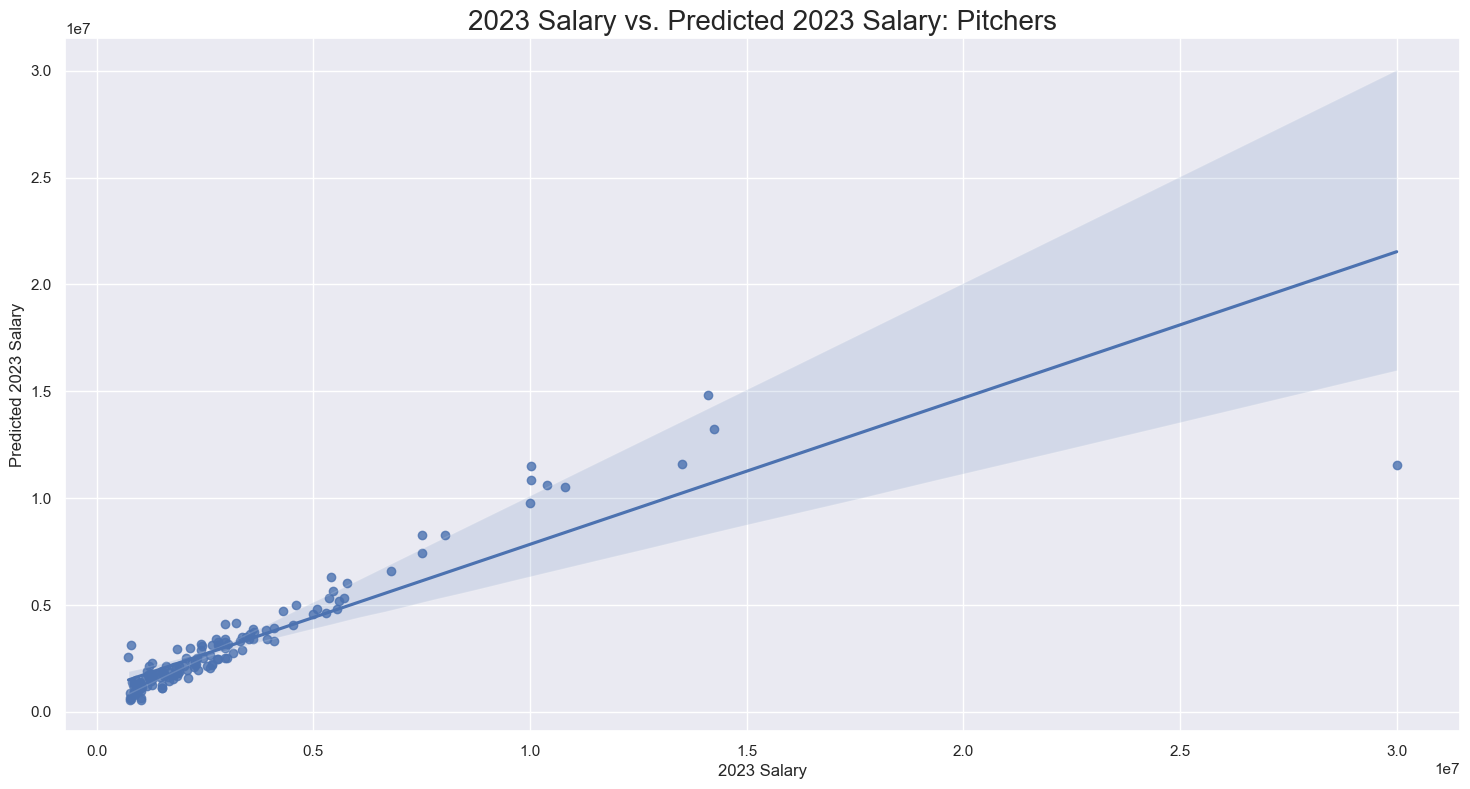

In [37]:
# Create plot actual vs. predicted salary, visualize error spread
sns.set(rc={"figure.figsize":(18, 9)})
sns.regplot(arb23_preds, x='2023 Salary', y='Predicted 2023 Salary').set_title('2023 Salary vs. Predicted 2023 Salary: Pitchers', fontsize = 20)

Text(0.5, 1.0, '2023 Salary vs. Predicted 2023 Salary: Pitchers (Colored)')

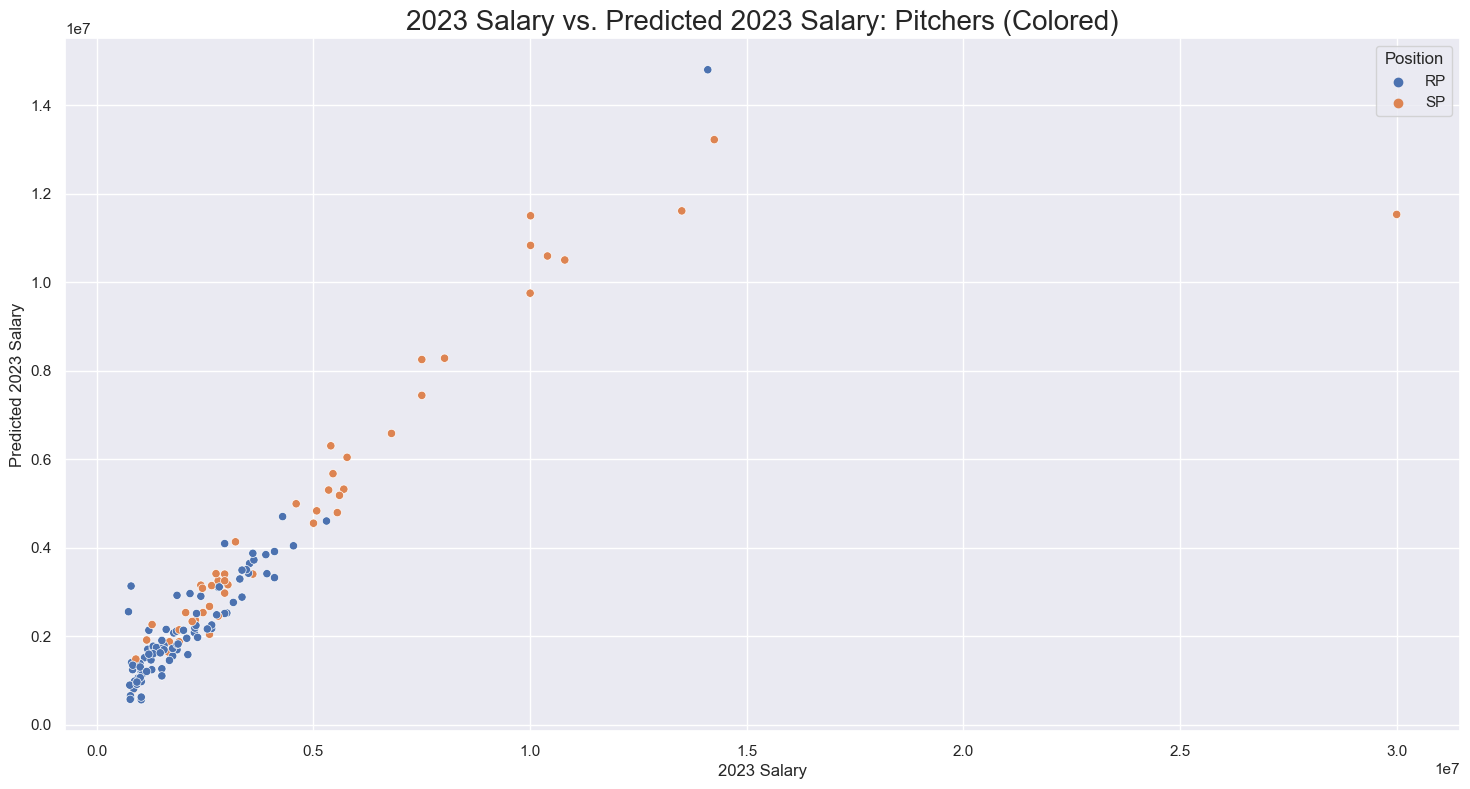

In [38]:
# Create scatterplot of actual vs. predicted salaries, color by Position
sns.scatterplot(arb23_preds, 
                x='2023 Salary', y='Predicted 2023 Salary', 
                hue='Position').set_title('2023 Salary vs. Predicted 2023 Salary: Pitchers (Colored)', fontsize = 20)

Text(0.5, 1.0, '2023 Salary vs. Predicted 2023 Salary: Pitchers (Colored & Dotted)')

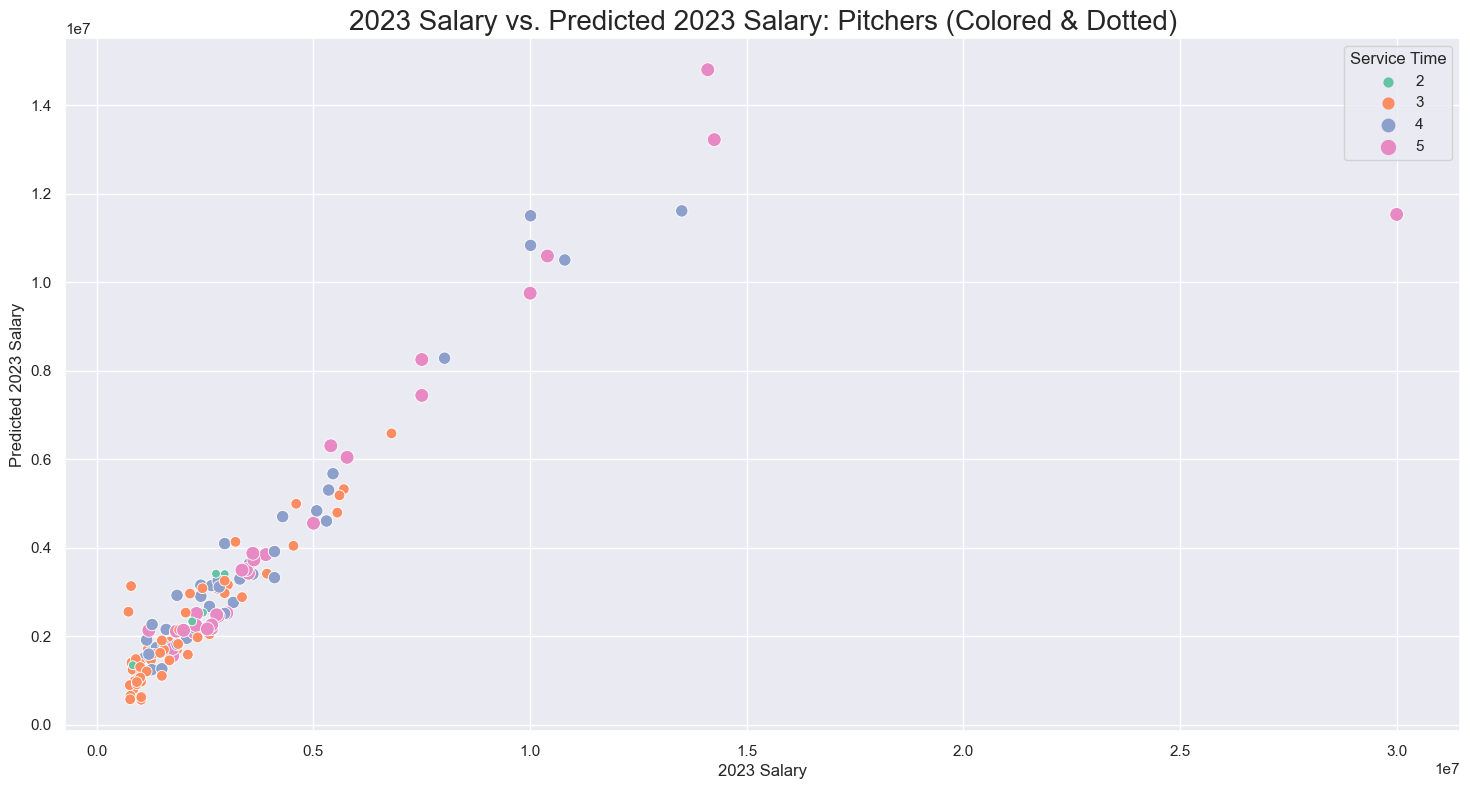

In [39]:
# Create scatterplot of actual vs. predicted salaries, color and size by service time
sns.scatterplot(arb23_preds, 
                x='2023 Salary', y='Predicted 2023 Salary', 
                hue='Service Time',
                size = 'Service Time', sizes= {2:40,3:60,4:80,5:100}, 
                palette="Set2").set_title('2023 Salary vs. Predicted 2023 Salary: Pitchers (Colored & Dotted)', fontsize = 20)

In [44]:
# Write predictions to Excel file
with pd.ExcelWriter('Predictions/preds.xlsx',mode='a') as writer:  
    arb23_preds.to_excel(writer, sheet_name='pitchers2')